In [21]:
from datetime import datetime, timedelta, date, time

from modules import *
import utils


In [2]:
%matplotlib inline
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/home/lndunn/.local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
datapath = '../data/nsfwind/clean'
wdata = pd.read_csv(os.path.join(datapath,'Wdata.csv'), parse_dates=['time',])
tdata = pd.read_csv(os.path.join(datapath,'Tdata.csv'), parse_dates=['time',])

wdata.head()

altitude  windSpeed  windDir       fname  obs                time
0     0.146       11.4    129.0  W14252.cns    0 2014-09-09 00:00:01
1     0.203       12.3    126.0  W14252.cns    0 2014-09-09 00:00:01
2     0.260       12.9    125.0  W14252.cns    0 2014-09-09 00:00:01
3     0.317       13.2    124.0  W14252.cns    0 2014-09-09 00:00:01
4     0.375       13.2    124.0  W14252.cns    0 2014-09-09 00:00:01

In [4]:
# pivot wind speed data
wdata = wdata.set_index(['altitude','time'], drop=False)
intervals, intervalMap = utils.mapIntervals(wdata.index.get_level_values('time'))

kwargs = {'to_rows': 'time',
          'to_cols': 'altitude',
          'rownames': intervals,
          'groups': intervalMap
          }

windSpeed = utils.pivot(wdata, varname='windSpeed', **kwargs)
windDir = utils.pivot(wdata, varname='windDir', **kwargs)

# pivot temperature data
tdata = tdata.set_index(['altitude','time'], drop=False)
intervals, intervalMap = utils.mapIntervals(tdata.index.get_level_values('time'))
kwargs['rownames'] = intervals
kwargs['groups'] = intervalMap
temp = utils.pivot(tdata, varname='temperature', **kwargs)


In [6]:
# fill in nulls, but not for gaps with more than one obs missing
idxNull0 = pd.isnull(windSpeed[[k for k in windSpeed.keys() if k < 1.5]])
idxNull1 = pd.isnull(windSpeed[[k for k in windSpeed.keys() if k < 1.5]].shift(1, axis=0))

_windSpeed = windSpeed.interpolate()[[k for k in windSpeed.keys() if k < 1.5]]
_windSpeed[idxNull0&idxNull1] = np.nan

idxComplete = pd.notnull(_windSpeed[[k for k in _windSpeed.keys() if k < 1.5]]).sum(axis=1)
X = _windSpeed.loc[idxComplete==idxComplete.max()]

baseTemp = temp[min(temp.keys())].loc[X.index]
baseDir = windDir[min(windDir.keys())].loc[X.index]



/home/lndunn/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


# Clustering

What are the characteristic mean wind speed profiles $\mu(h)$?
What is the variance about that mean $\sigma(h)$?

Can we use $\mu$ and $\sigma$ to determine the optimal number of clusters?
- What is the number of clusters that minimizes $\sigma(h)$
- ...

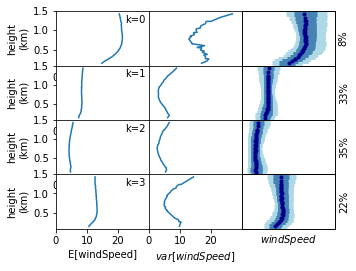

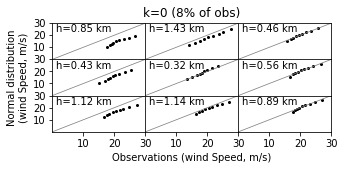

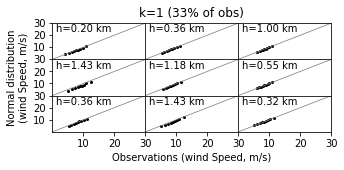

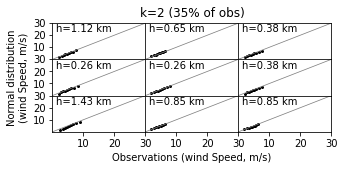

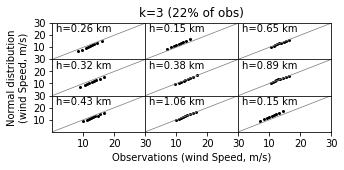

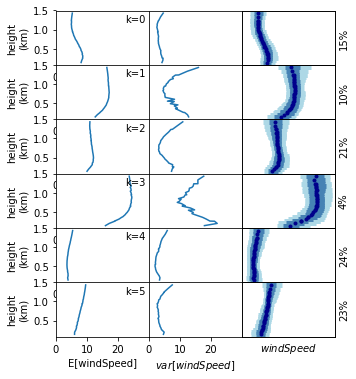

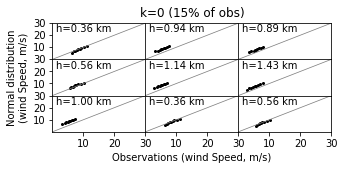

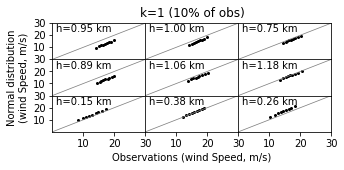

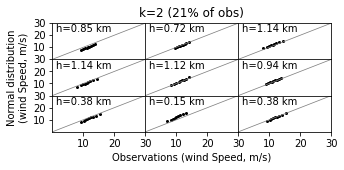

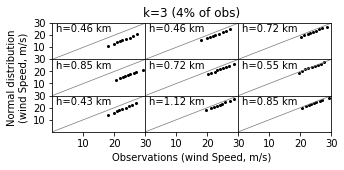

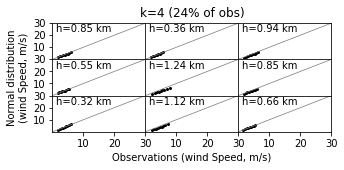

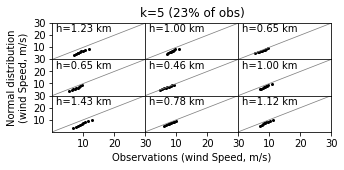

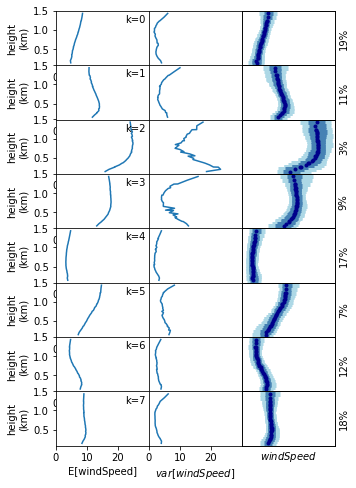

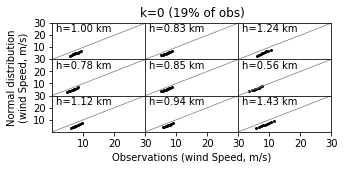

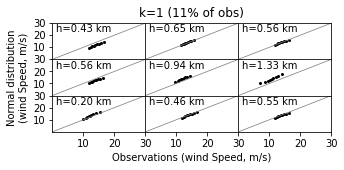

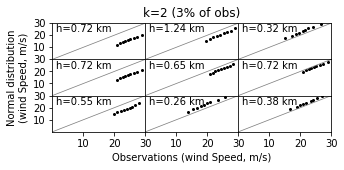

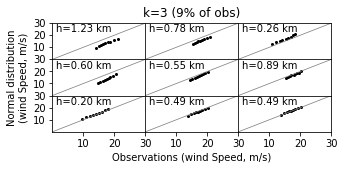

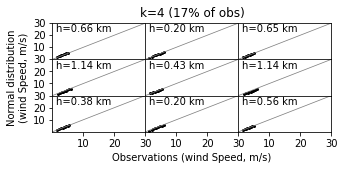

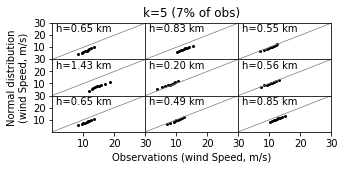

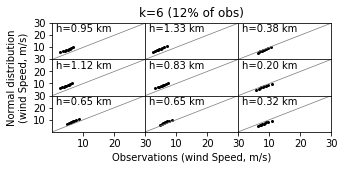

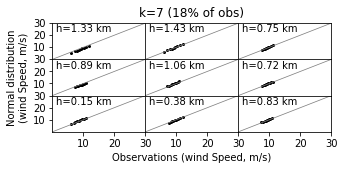

In [7]:
for nclusters in range(4,10,2):
    clusters = cluster.KMeans(n_clusters=nclusters).fit(X)
    
    fig, ax = plt.subplots(nrows=nclusters, ncols=3, figsize=(5,1*nclusters))

    mumax = 1
    sigmax = 1
    
    for k in range(nclusters):
        _data = (X.loc[clusters.labels_==k])

        means = pd.Series(_data.keys(), clusters.cluster_centers_[k,:]).sort_values()
        sigmas = pd.Series(_data.keys(), _data.var(axis=0)).sort_values()
        qtiles = _data.quantile(q=[0.1,0.25,0.5,0.75,0.9])
        
        # GENERATE Q-Q PLOT
        _fig, _ax = plt.subplots(nrows=3, ncols=3, figsize=(5,2))
        hts = np.random.choice(_data.keys(), 9)
        it = np.nditer(hts, flags=['multi_index'])
        qobs = _data.quantile(q=np.arange(0,1,0.1))
        for j, h in enumerate(hts):
            qnorm = stats.norm.ppf(np.arange(0,1,0.1), loc=clusters.cluster_centers_[k,j], scale=np.std(_data[h]))
            _ax[j%3, j/3].plot([0,30],[0,30], color='0.5', lw=0.75)
            _ax[j%3, j/3].scatter(qobs[h], qnorm, marker='o', color='k', s=4)
            _ax[j%3, j/3].set_xlim((0,30))
            _ax[j%3, j/3].set_ylim((0,30))
            if j/3>0:
                _ax[j%3,j/3].set_yticks([])
            else:
                _ax[j%3,j/3].set_yticks([10,20,30])
            if j%3<2:
                _ax[j%3,j/3].set_xticks([])
            else:
                _ax[j%3,j/3].set_xticks([10,20,30])
            _ax[j%3,j/3].text(1,29,'h=%.2f km'%(h),ha='left', va='top')
        _ax[0,1].set_title('k=%i (%i%% of obs)'%(k, 100*len(_data)/float(len(X))))
        _ax[1,0].set_ylabel('Normal distribution\n(wind Speed, m/s)')
        _ax[2,1].set_xlabel('Observations (wind Speed, m/s)')
        _fig.subplots_adjust(hspace=0, wspace=0)
        
        means.plot(ax=ax[k,0])
        sigmas.plot(ax=ax[k,1])
        
        ax[k,2].hlines(qtiles.keys(), qtiles.loc[0.1], qtiles.loc[0.9], color='lightblue', lw=5)
        ax[k,2].hlines(qtiles.keys(), qtiles.loc[0.25], qtiles.loc[0.75], color='steelblue', lw=5)
        ax[k,2].plot(qtiles.loc[0.5], qtiles.keys(), ls=' ', marker='.', color='darkblue')
        __ax = ax[k,2].twinx()
        __ax.set_yticks([])
        __ax.set_xticks([])
        __ax.set_ylabel('%i%%'%(100*len(_data)/float(len(X))))
        ax[k,0].text(29,1.4,'k=%i'%(k), ha='right', va='top')
        
        if k < ax.shape[0]-1:
            ax[k,0].set_xticks([])
            ax[k,1].set_xticks([])
            ax[k,2].set_xticks([])
        if k==ax.shape[0]-1:
            ax[k,0].set_xlabel(r'E[windSpeed]')
            ax[k,1].set_xlabel(r'$var[windSpeed]$')
            ax[k,2].set_xlabel(r'$windSpeed$')
        ax[k,0].set_ylabel('height\n(km)')
        ax[k,1].set_yticks([])
        ax[k,2].set_yticks([])
        
    for k in range(nclusters):
        ax[k,0].set_xlim((0,30))
        ax[k,1].set_xlim((0,30))
        ax[k,2].set_xlim((0,30))
        ax[k,0].set_xticks([0,10,20])
        ax[k,1].set_xticks([0,10,20])
        
        
    fig.subplots_adjust(hspace=0, wspace=0)
    plt.show()

In [137]:
intervals, intervalMap = utils.mapIntervals(X.index, freq='24H')
dailyobs = intervalMap.groupby(intervalMap).count()
dailyobs.tail()
# dailyobs.hist()

2014-09-05 04:00:00    47
2014-09-06 04:00:00    37
2014-09-07 04:00:00    35
2014-09-08 04:00:00    45
2014-09-09 04:00:00    44
dtype: int64

In [25]:
def populateFeatures(X, h=0, daynight=True, hour=False):
    df = pd.DataFrame(index=X.index)
    
    wskey = pd.Series(np.abs(windSpeed.keys()-h), index=windSpeed.keys()).idxmin()
    wdkey = pd.Series(np.abs(windDir.keys()-h), index=windDir.keys()).idxmin()
    tkey = pd.Series(np.abs(temp.keys()-h), index=temp.keys()).idxmin()
    df['windSpeed'] = X[min(X.keys())]
    df['windDir'] = windDir[min(X.keys())]
    df['temperature'] = temp[min(temp.keys())].loc[X.index]
    
    
    idxDay = (X.index.hour>8)&(X.index.hour<17)
    df['daytime'] = 0
    df['daytime'].loc[idxDay] = 1
    
    idxNight = (X.index.hour<6)|(X.index.hour>19)
    df['nighttime'] = 0
    df['nighttime'].loc[idxNight] = 1
    
    return df

def testtrainsplit(X, method='first', testsize=0.5):
    if method=='first':
        ixTrain = X.iloc[:int((1-testsize)*len(X))].index
    elif method=='random':
        ixTrain = np.random.choice(X.index, int((1-testsize)*len(X)))
    ixTest = list(set(X.index)-set(ixTrain))
    return ixTrain, ixTest

def clustering(X, nclusters=nclusters):
    return cluster.KMeans(n_clusters=nclusters).fit(X)

In [15]:
kwarg_dicts = {'cluster': [{'nclusters': [6,]},],
       'testtrainsplit': [{'method':'first', 'testsize':0.5},
                         {'method': 'random', 'testsize':0.5},
                         {'method':'first', 'testsize':0.75},
                         {'method': 'random', 'testsize':0.75}],
        'populateFeatures': [{'h': h} for h in X.keys()]
       }



38


In [ ]:
for ckwargs in kwarg_dicts['cluster']:
    for tkwargs in kwarg_dicts['testtrainsplit']:
        for fkwargs in kwarg_dicts['populateFeatures']:
            clusters = cluster(X, **clusterkeys)
            y = clusters.labels_

            pdfs = np.zeros(shape=(nclusters, len(X.keys()), 100))
            for k in range(nclusters):
                _clusterdf = X.loc[y==k]
                for i, h in enumerate(X.keys()):
                    pdfs[k,i,:] = stats.norm.pdf(np.linspace(0,35,100), loc=clusters.cluster_centers_[k,i], scale=np.std(_clusterdf[h]))
                    pdfs[k,i,:] /= sum(pdfs[k,i,:])

            features = populateFeatures(X, h=min(X.keys()))
            _idx = pd.isnull(features).sum(axis=1)==0

            _features = features[_idx]
            _X = X[_idx]
            _y = y[_idx]

            ixTrain, ixTest = testtrainsplit(_X, method='first', testsize=0.5)
            ytrain, ytest = _y.loc[ixTrain], _y.loc[ixTest]

            logit = linear_model.LogisticRegression().fit(_features.loc[ixTrain], _y[ixTrain])
            cluster_prob = logit.predict_proba(_features)

            probabs = np.zeros(shape=(len(_X), len(_X.keys()), 100))
            y_hat_train = logit.predict(_features[ixTrain])
            y_hat_test = logit.predict(_features[ixTest])
            for i, h in enumerate(X.keys()):
                probabs[:,i,:] = cluster_prob.dot(pdfs[:,i,:])
                
            


In [76]:

for nclusters in [6,]:
    clusters = clustering(X, nclusters=nclusters)
    y = clusters.labels_
    
    pdfs = np.zeros(shape=(nclusters, len(X.keys()), 100))
    for k in range(nclusters):
        _clusterdf = X.loc[y==k]
        for i, h in enumerate(X.keys()):
            pdfs[k,i,:] = stats.norm.pdf(np.linspace(0,35,100), loc=clusters.cluster_centers_[k,i], scale=np.std(_clusterdf[h]))
            pdfs[k,i,:] /= sum(pdfs[k,i,:])
            
    features = populateFeatures(X, h=min(X.keys()))
    _idx = pd.isnull(features).sum(axis=1)==0

    _features = features[_idx]
    _X = X[_idx]
    _y = y[_idx]

    ixTrain, ixTest = testtrainsplit(_X, method='first', testsize=0.5)
    idxTrain = _X.index.isin(_X.iloc[:len(_X)/2].index)
    idxTest = ~idxTrain
    
    ytrain = _y[idxTrain]
    ytest = _y[idxTest]
    
    logit = linear_model.LogisticRegression().fit(_features.loc[idxTrain], _y[idxTrain])
    cluster_prob = logit.predict_proba(_features)

    probabs = np.zeros(shape=(len(_X), len(_X.keys()), 100))
    y_hat_train = logit.predict(_features[idxTrain])
    y_hat_test = logit.predict(_features[idxTest])
    for i, h in enumerate(X.keys()):
        probabs[:,i,:] = cluster_prob.dot(pdfs[:,i,:])
#         probabs[:,i,:] /= probabs[:,i,:].sum(axis=0)
#         hprobs = pd.DataFrame(y_hat.dot(pdfs[:,i,:]), columns=np.linspace(0,35,100))
#         hprobs['h'] = h
#         hprobs['t'] = _X.index
#         probabs.append(hprobs)
#     probabs = pd.concat(probabs).set_index(['t'])

/home/lndunn/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


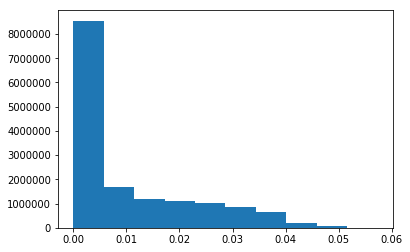

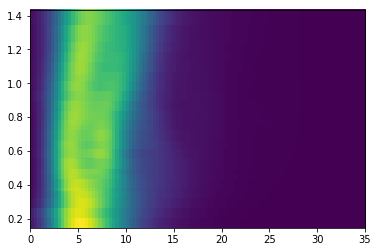

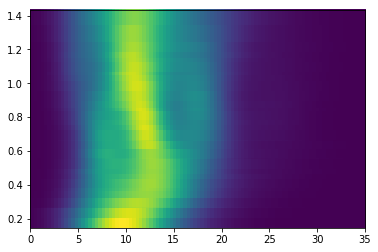

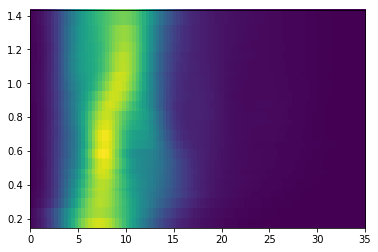

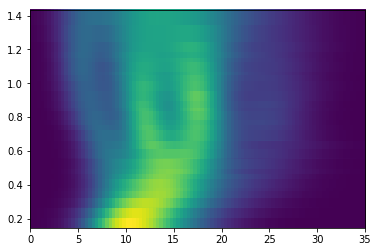

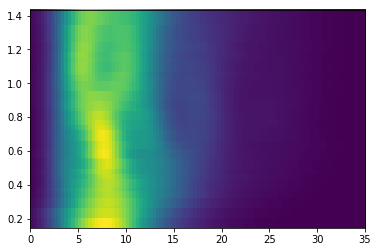

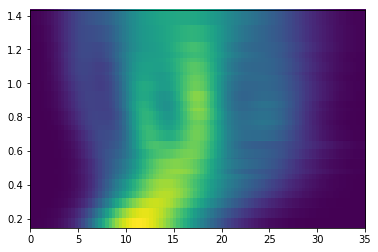

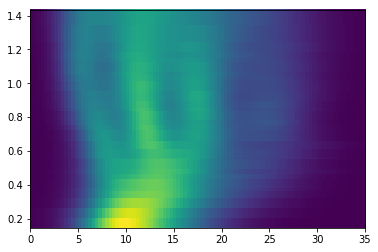

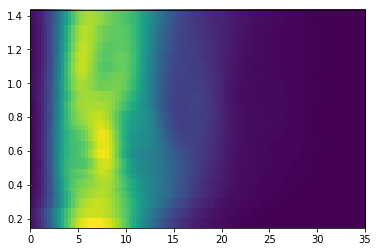

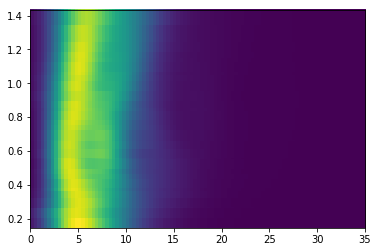

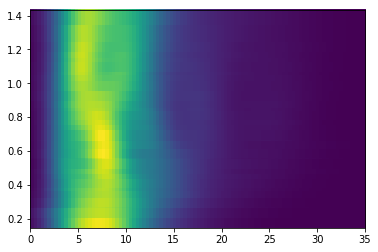

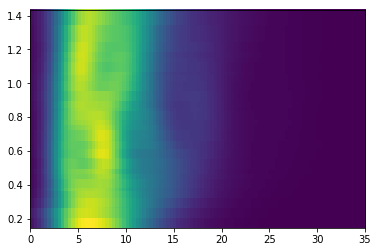

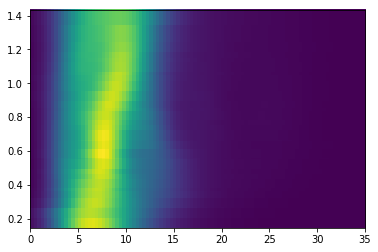

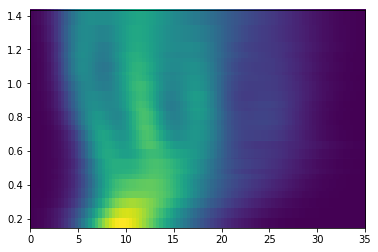

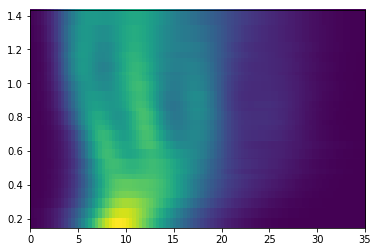

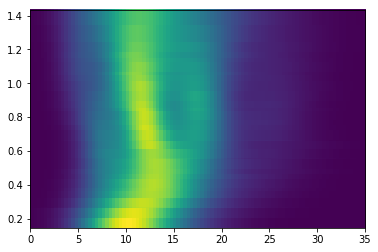

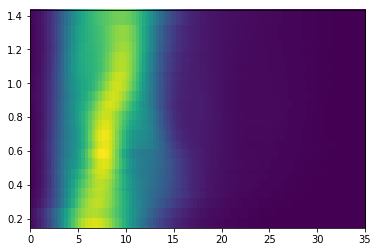

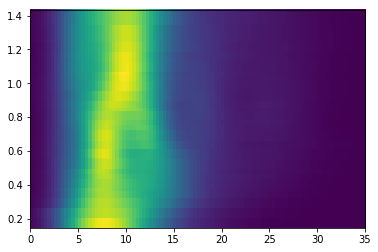

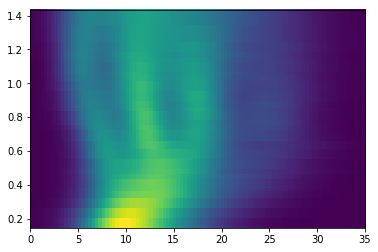

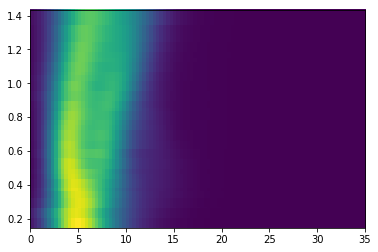

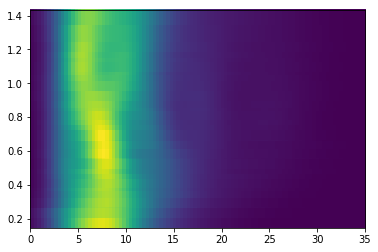

In [88]:
probabs.shape

fig, ax = plt.subplots()
ax.hist(probabs.flatten())
plt.show()

xvals, yvals = np.meshgrid(np.linspace(0,35,100), X.keys()[X.keys()<X.keys().max()])

for n in np.random.choice(probabs.shape[0], 20):
    fig, ax = plt.subplots()
    ax.hist2d(xvals.flatten(), yvals.flatten(), weights=(probabs[n,:-1,:]).flatten(), bins=[np.linspace(0,35,100), X.keys().sort_values()])
    plt.show()

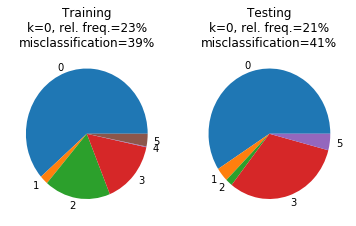

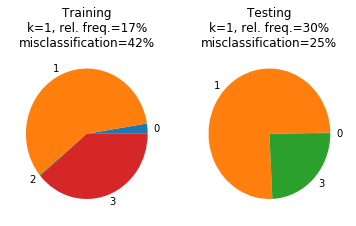

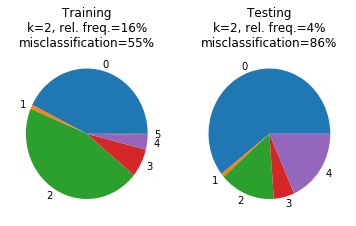

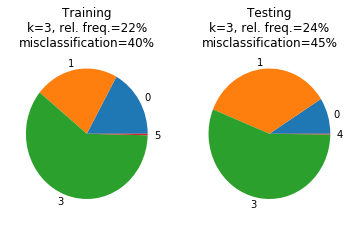

KeyError: u'the label [4] is not in the [index]'

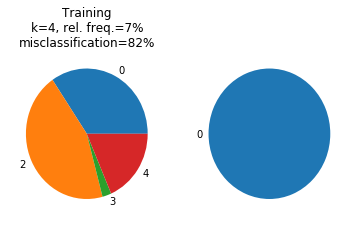

In [314]:
# ytrain, ytest = _y[idxTrain], _y[idxTest]
for k in range(nclusters):
    fig, ax = plt.subplots(ncols=2, figsize=(6,3))

    idxK = ytrain==k
    obs = pd.Series(y_hat_train[idxK])
    counts = obs.groupby(y_hat_train[idxK]).count()
    ax[0].pie(counts, labels=counts.index)
    ax[0].set_title('Training\nk=%i, rel. freq.=%i%%\nmisclassification=%i%%'%(k, 100*sum(idxK)/len(ytrain), 100-100*counts.loc[k]/sum(counts)))
    
    idxK = ytest==k
    obs = pd.Series(y_hat_test[idxK])
    counts = obs.groupby(y_hat_test[idxK]).count()
    ax[1].pie(counts, labels=counts.index)
    ax[1].set_title('Testing\nk=%i, rel. freq.=%i%%\nmisclassification=%i%%'%(k, 100*sum(idxK)/len(ytrain), 100-100*counts.loc[k]/sum(counts)))
    plt.show()

In [35]:
yvals

array([[0.146, 0.146, 0.146, ..., 0.146, 0.146, 0.146],
       [0.203, 0.203, 0.203, ..., 0.203, 0.203, 0.203],
       [0.26 , 0.26 , 0.26 , ..., 0.26 , 0.26 , 0.26 ],
       ...,
       [1.236, 1.236, 1.236, ..., 1.236, 1.236, 1.236],
       [1.334, 1.334, 1.334, ..., 1.334, 1.334, 1.334],
       [1.431, 1.431, 1.431, ..., 1.431, 1.431, 1.431]])

In [303]:
y_hat_train[:5]

array([1, 0, 3, 3, 1], dtype=int32)

In [52]:

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)


def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())


In [50]:
hist = ax.hist2d(xvals.flatten(), yvals.flatten(), weights=(probabs[0,:,:]).flatten(), bins=[100, len(X.keys())])
dir(hist[3])

['_A',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getstate__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alpha',
 '_animated',
 '_axes',
 '_check_unsampled_image',
 '_clipon',
 '_clippath',
 '_contains',
 '_draw_unsampled_image',
 '_extent',
 '_filternorm',
 '_filterrad',
 '_gid',
 '_imcache',
 '_interpd',
 '_interpdr',
 '_interpolation',
 '_label',
 '_make_image',
 '_mouseover',
 '_oid',
 '_path_effects',
 '_picker',
 '_prop_order',
 '_propobservers',
 '_rasterized',
 '_remove_method',
 '_resample',
 '_rgbacache',
 '_set_gc_clip',
 '_sketch',
 '_snap',
 '_stale',
 '_sticky_edges',
 '_transform',
 '_transformSet',
 '_url',
 '_visible',
 'add_callback',
 'add_checker',
 'aname',
 'autoscale',
 'autoscale_None',
 'axes',
 'callbacksSM',
 'can_composite',
 'changed',
 'check_update',


In [96]:
from matplotlib import colors

# def make_video(_X, probabs, dest):
times = pd.date_range(start=_X.index.min(), end=_X.index.max(), freq='30min')[4000:4500]
heights = _X.keys()

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(xlim=(0, 30), ylim=(0, 1.5))
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Altitude (km)')

alphas = [1,0.6,0.4,0.2,0.1,1]
linecolors=['k','k','k','k','k','k']
lines = [ax.plot([], [], lw=3, color=linecolors[i], alpha=alpha)[0] for i, alpha in enumerate(alphas)]
# im = plt.imshow(np.zeros(shape=(probabs.shape[2], probabs.shape[1])), 
#                 extent=[0, 35, min(_X.keys()), max(_X.keys()), ], 
#                 aspect='auto',
#                 animated=True, interpolation='gaussian', zorder=0,
#                norm = colors.Normalize(0,probabs.max().max().max()),
#                cmap='Greens')
clustercolors = ['b','g','m','r','c','darkgreen',]

xvals, yvals = np.meshgrid(np.linspace(0,35,100), X.keys()[X.keys()<X.keys().max()])
histkwargs = {'bins':[np.linspace(0,35,100), X.keys().sort_values()], 
              'cmin':0, 'cmap':'Blues', 'alpha':0.5}
histargs = [xvals.flatten(), yvals.flatten()]
hist = plt.hist2d(*histargs, weights=(probabs[0,:-1,:]).flatten(), **histkwargs)[3]
# im = ax.imshow(hist[3])
# initialization function: plot the background of each frame
def init():
    for j in range(len(lines)):
        lines[j].set_data([], [])
#     im.set_array(np.zeros(shape=(probabs.shape[2], probabs.shape[1])))
    return lines[0], lines[1], lines[2], lines[3], lines[4], lines[5], hist

# animation function.  This is called sequentially
def animate(i):
    for j in range(len(lines)-1):
        if i-j<0:
            continue
        if times[i-j] not in _X.index:
            lines[j].set_data([], [])
        else:
            data = _X.loc[times[i-j]].sort_index()
            x = data.tolist()
            y = data.index
            lines[j].set_data(x, y)
#             lines[j].set_color(clustercolors[_y[i-j]])
    
    windspeeds = pd.DataFrame(probabs[i,:,:].T, columns=_X.keys(), index=np.linspace(0,35,100))
    expectation = windspeeds.idxmax().sort_index()
    lines[len(lines)-1].set_data(expectation.tolist(), expectation.index)
    ax.set_title(times[i].strftime('%Y-%m-%d %H'))
    
    hist = ax.hist2d(*histargs, weights=(probabs[i,:-1,:]).flatten(), **histkwargs)[3]
    return lines[0], lines[1], lines[2], lines[3], lines[4], lines[5], hist

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(times), interval=200, blit=True)

# call our new function to display the animation
display_animation(anim)


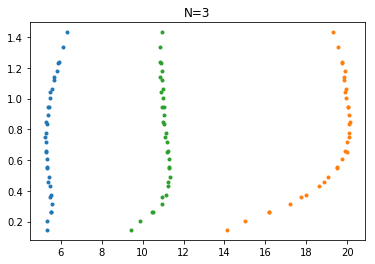

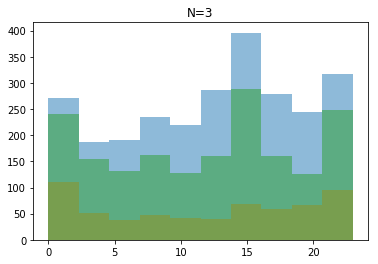

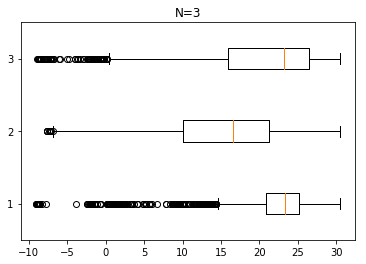

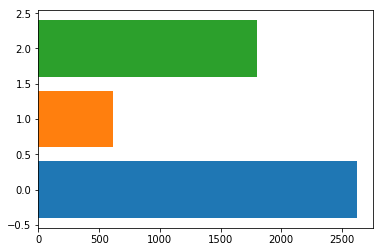

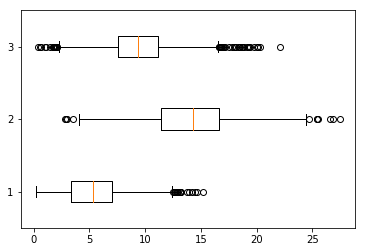

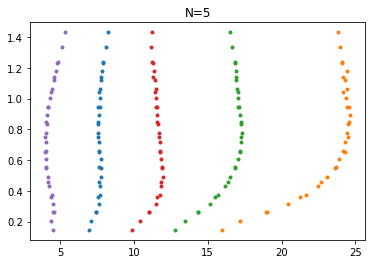

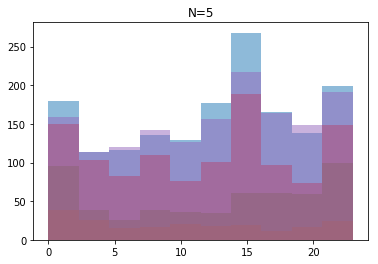

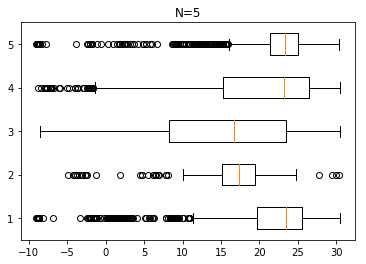

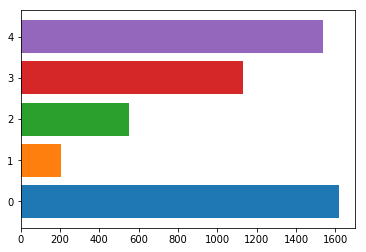

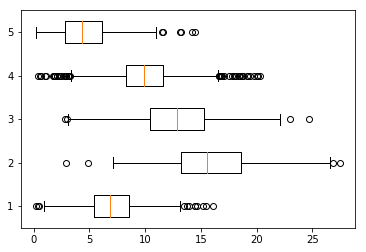

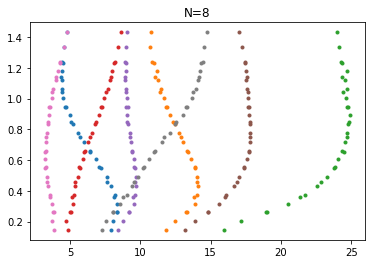

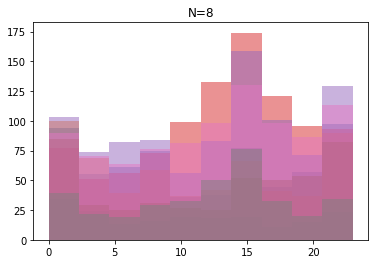

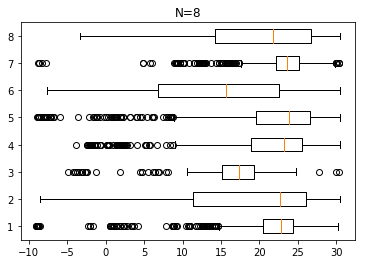

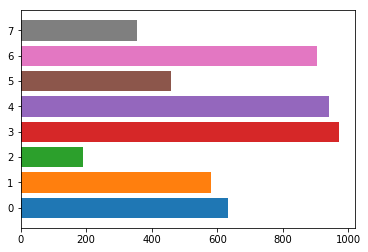

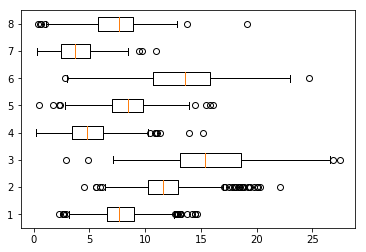

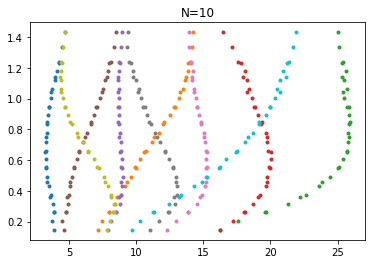

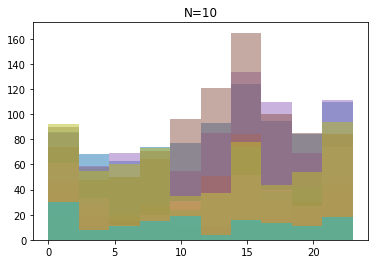

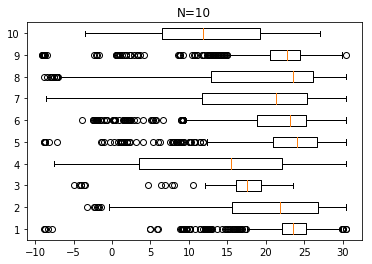

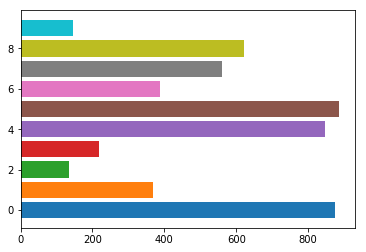

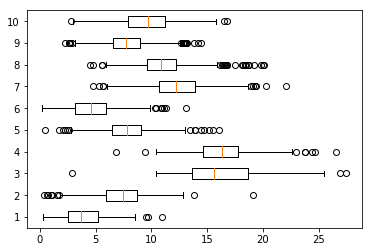

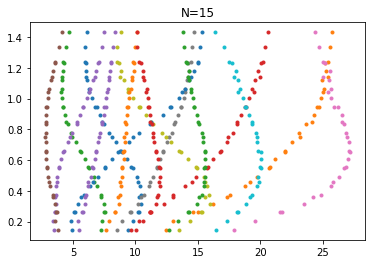

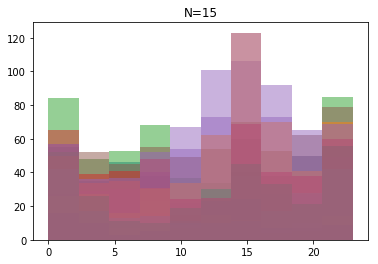

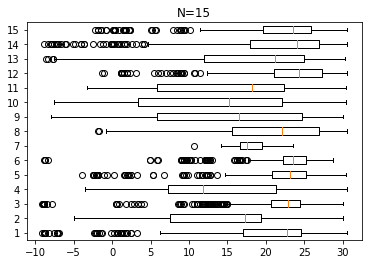

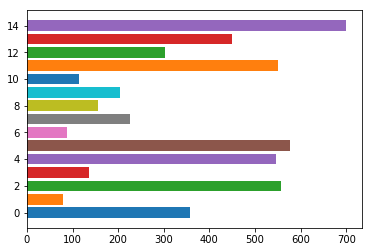

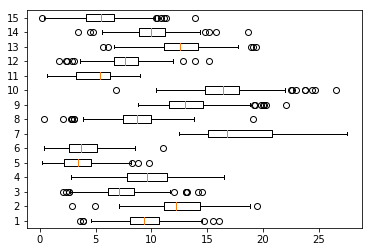

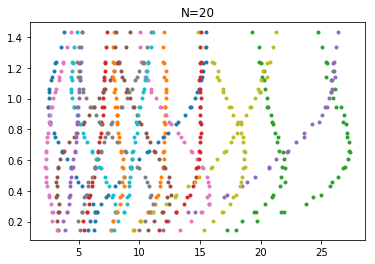

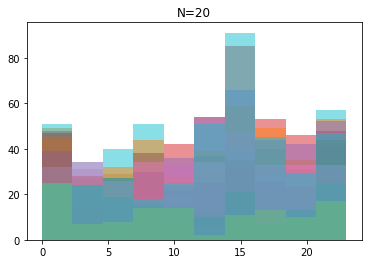

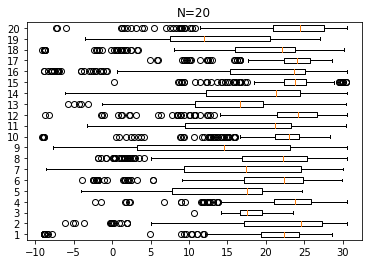

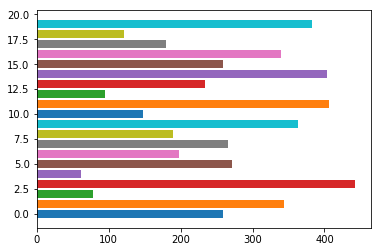

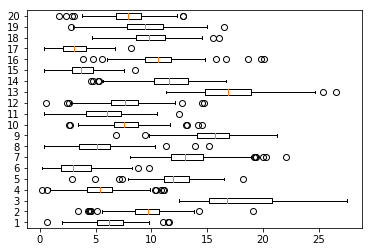

In [43]:
for nclusters in [3,5,8,10,15,20]:
    clusters = cluster.KMeans(n_clusters=nclusters).fit(X)
    fig, ax = plt.subplots()
    for k in range(clusters):
        ax.plot()
#     features = pd.DataFrame(columns=['windSpeed','windDir','temp','time',], index=X.index)
#     href = min(X.keys())
#     for t in X.index:
#         features.loc[t] = [_windSpeed[href].loc[t], windDir[href].loc[t], baseTemp.loc[t], t.hour]
        
#     X_train, X_test, y_train, y_test = model_selection.train_test_split(features, clusters)
    
#     logit = linear_model.LogisticRegression().fit(X_train, y_train)
    
#     fig1, ax1 = plt.subplots()
#     fig2, ax2 = plt.subplots()
#     fig3, ax3 = plt.subplots()
#     fig4, ax4 = plt.subplots()
#     fig5, ax5 = plt.subplots()
    
#     temps = []
#     baseWS = []
#     for k in range(nclusters):
#         ax1.plot(clusters.cluster_centers_[k,:], X.keys(), ls=' ', marker='.')

#         idx = clusters.labels_==k
#         ax2.hist(X[idx].index.hour, stacked=False, alpha=0.5)        
#         ax4.barh(k, sum(idx))
        
#         temps.append(baseTemp[idx&pd.notnull(baseTemp)])
#         baseWS.append(X[min(X.keys())][idx])
        
#     for ax in [ax1, ax2, ax3]:
#         ax.set_title('N=%i'%(nclusters))
#     ax3.boxplot(temps, vert=False)
#     ax5.boxplot(baseWS, vert=False)
    
#     plt.show()

In [140]:
idxnulls = pd.notnull(windSpeed[[k for k in windSpeed.keys() if k < 1.5]])
idxnulls2 = pd.notnull(windSpeed[[k for k in windSpeed.keys() if k < 1.5]].shift(1, axis=0))

windSpeed = windSpeed.interpolate()
windSpeed[~(idxnulls&idxnulls2)] = np.nan

In [144]:
windSpeed.head()

0.146  0.203  0.260  0.317  0.375  0.432  0.489  0.546  \
2014-01-01 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2014-01-01 00:30:00    6.9    6.6    6.7    7.3    8.4    9.1    9.6   11.1   
2014-01-01 01:00:00    6.3    5.5    6.2    6.7    7.4    8.3    9.4   10.3   
2014-01-01 01:30:00    5.0    4.4    5.5    6.1    6.8    8.1    9.0    9.1   
2014-01-01 02:00:00    5.1    4.7    5.6    6.6    7.3    7.2    7.7    8.2   

                     0.604  0.661  ...    2.209  2.306  2.404  2.501  2.598  \
2014-01-01 00:00:00    NaN    NaN  ...      NaN    NaN    NaN    NaN    NaN   
2014-01-01 00:30:00   11.9   10.7  ...      NaN    NaN    NaN    NaN    NaN   
2014-01-01 01:00:00   11.0   10.2  ...      NaN    NaN    NaN    NaN    NaN   
2014-01-01 01:30:00    9.4    9.7  ...      NaN    NaN    NaN    NaN    NaN   
2014-01-01 02:00:00    8.6   10.0  ...      NaN    NaN    NaN    NaN    NaN   

                     2.695  2.793  2.890  2.987  3.084  
2014-01-01 00:00:00    NaN    NaN    NaN    NaN    NaN  
2014-01-01 00:30:00    NaN    NaN    NaN    NaN    NaN  
2014-01-01 01:00:00    NaN    NaN    NaN    NaN    NaN  
2014-01-01 01:30:00    NaN    NaN    NaN    NaN    NaN  
2014-01-01 02:00:00    NaN    NaN    NaN    NaN    NaN  

[5 rows x 50 columns]

In [145]:
_idxnulls = pd.notnull(windSpeed[[k for k in windSpeed.keys() if k < 1.5]]).sum(axis=1)
sum((idxnulls))

In [146]:
_idxnulls

2014-01-01 00:00:00     0
2014-01-01 00:30:00    24
2014-01-01 01:00:00    29
2014-01-01 01:30:00    29
2014-01-01 02:00:00    29
2014-01-01 02:30:00    29
2014-01-01 03:00:00    30
2014-01-01 03:30:00    31
2014-01-01 04:00:00    31
2014-01-01 04:30:00    32
2014-01-01 05:00:00    33
2014-01-01 05:30:00    33
2014-01-01 06:00:00    33
2014-01-01 06:30:00    33
2014-01-01 07:00:00    33
2014-01-01 07:30:00    33
2014-01-01 08:00:00    33
2014-01-01 08:30:00    33
2014-01-01 09:00:00    33
2014-01-01 09:30:00    33
2014-01-01 10:00:00    33
2014-01-01 10:30:00    33
2014-01-01 11:00:00    33
2014-01-01 11:30:00    33
2014-01-01 12:00:00    33
2014-01-01 12:30:00    33
2014-01-01 13:00:00    33
2014-01-01 13:30:00    33
2014-01-01 14:00:00    33
2014-01-01 14:30:00    33
                       ..
2014-09-09 12:00:00    33
2014-09-09 12:30:00    33
2014-09-09 13:00:00    33
2014-09-09 13:30:00    33
2014-09-09 14:00:00    33
2014-09-09 14:30:00    33
2014-09-09 15:00:00    33
2014-09-09 1

In [28]:
times[:100]

DatetimeIndex(['2014-09-09 00:00:01', '2014-09-09 00:01:14',
               '2014-09-09 00:30:01', '2014-09-09 00:31:14',
               '2014-09-09 01:00:01', '2014-09-09 01:01:14',
               '2014-09-09 01:30:01', '2014-09-09 01:31:13',
               '2014-09-09 02:00:13', '2014-09-09 02:01:26',
               '2014-09-09 02:30:03', '2014-09-09 02:31:16',
               '2014-09-09 03:00:03', '2014-09-09 03:01:15',
               '2014-09-09 03:30:02', '2014-09-09 03:31:15',
               '2014-09-09 04:00:02', '2014-09-09 04:01:14',
               '2014-09-09 04:30:01', '2014-09-09 04:31:14',
               '2014-09-09 05:00:01', '2014-09-09 05:01:14',
               '2014-09-09 05:30:01', '2014-09-09 05:31:13',
               '2014-09-09 06:00:14', '2014-09-09 06:01:26',
               '2014-09-09 06:30:03', '2014-09-09 06:31:16',
               '2014-09-09 07:00:06', '2014-09-09 07:01:19',
               '2014-09-09 07:30:09', '2014-09-09 07:31:22',
               '2014-09-